[View in Colaboratory](https://colab.research.google.com/github/hogezero/cifar10/blob/master/cifar10.ipynb)

# chainer セットアップ

In [3]:
# chainerセットアップ
# https://qiita.com/keisuke-umezawa/items/4e99c2a4f5f07567444c

# Install Chainer and CuPy!

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'
!apt-get install graphviz
!pip install 'chaineripy'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 2 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 1s (16.2 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###..

    100% |████████████████████████████████| 205.2MB 6.3kB/s 
    100% |████████████████████████████████| 81kB 2.3MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 368kB 1.9MB/s 
  Running setup.py bdist_wheel for chainer ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/7a/e7/26/c13ce14e84f7f2a7209a31f5a1e327b8c681c5bcb3abcd0bec
  Running setup.py bdist_wheel for filelock ... - done
  Stored in directory: /content/.cache/pip/wheels/35/ba/67/4cc48738870c3b54f9e3b5d78bf9de130befb70c1d359faf8b
Successfully built chainer filelock
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed

Get:9 http://archive.ubuntu.com/ubuntu artful/main amd64 libpixman-1-0 amd64 0.34.0-1 [230 kB]
Get:10 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-render0 amd64 1.12-1ubuntu1 [14.8 kB]
Get:11 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-shm0 amd64 1.12-1ubuntu1 [5,482 B]
Get:12 http://archive.ubuntu.com/ubuntu artful/main amd64 libcairo2 amd64 1.14.10-1ubuntu1 [558 kB]
Get:13 http://archive.ubuntu.com/ubuntu artful/main amd64 libltdl7 amd64 2.4.6-2 [38.8 kB]
Get:14 http://archive.ubuntu.com/ubuntu artful/main amd64 libthai-data all 0.1.26-3 [132 kB]
Get:15 http://archive.ubuntu.com/ubuntu artful/main amd64 libdatrie1 amd64 0.2.10-5 [17.6 kB]
Get:16 http://archive.ubuntu.com/ubuntu artful/main amd64 libthai0 amd64 0.1.26-3 [17.7 kB]
Get:17 http://archive.ubuntu.com/ubuntu artful/main amd64 libpango-1.0-0 amd64 1.40.12-1 [152 kB]
Get:18 http://archive.ubuntu.com/ubuntu artful/main amd64 libgraphite2-3 amd64 1.3.10-2 [78.3 kB]
Get:19 http://archive.ubuntu.com/ubu

Selecting previously unselected package libpangocairo-1.0-0:amd64.
Preparing to unpack .../20-libpangocairo-1.0-0_1.40.12-1_amd64.deb ...
Unpacking libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Selecting previously unselected package libpathplan4.
Preparing to unpack .../21-libpathplan4_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libpathplan4 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libgvc6.
Preparing to unpack .../22-libgvc6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libgvc6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libgvpr2.
Preparing to unpack .../23-libgvpr2_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libgvpr2 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libxt6:amd64.
Preparing to unpack .../24-libxt6_1%3a1.1.5-1_amd64.deb ...
Unpacking libxt6:amd64 (1:1.1.5-1) ...
Selecting previously unselected package libxmu6:amd64.
Preparing to unpack .../25-libxmu6_2%3a1.1.2-2_amd64.deb ...
Unpacking libxmu6:amd64 (2:1.1.2-2) ...
Selecting previ

    100% |████████████████████████████████| 2.2MB 584kB/s 
  Running setup.py bdist_wheel for pandocfilters ... - done
  Stored in directory: /content/.cache/pip/wheels/39/01/56/f1b08a6275acc59e846fa4c1e1b65dbc1919f20157d9e66c20
Successfully built pandocfilters
  Found existing installation: pandocfilters 1.3.0
    Uninstalling pandocfilters-1.3.0:
      Successfully uninstalled pandocfilters-1.3.0
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# 必要なものをインポート

In [4]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

# chainer
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import split_dataset
import pandas as pd
pd.options.display.precision = 3      # 有効桁数を指定

/usr/local/lib/python3.6/dist-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


**GPU確認**

In [5]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


# データセット
**データセット取得 (CIFAR-10)**

In [6]:
(train_original, test_original) = chainer.datasets.get_cifar10()

**データセット分割**

In [0]:
train, test = split_dataset(train_original, int(len(train_original) * 0.8))

**ラベルの名前**

In [0]:
# ラベルの名前
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

**CIFAR-10学習画像表示**

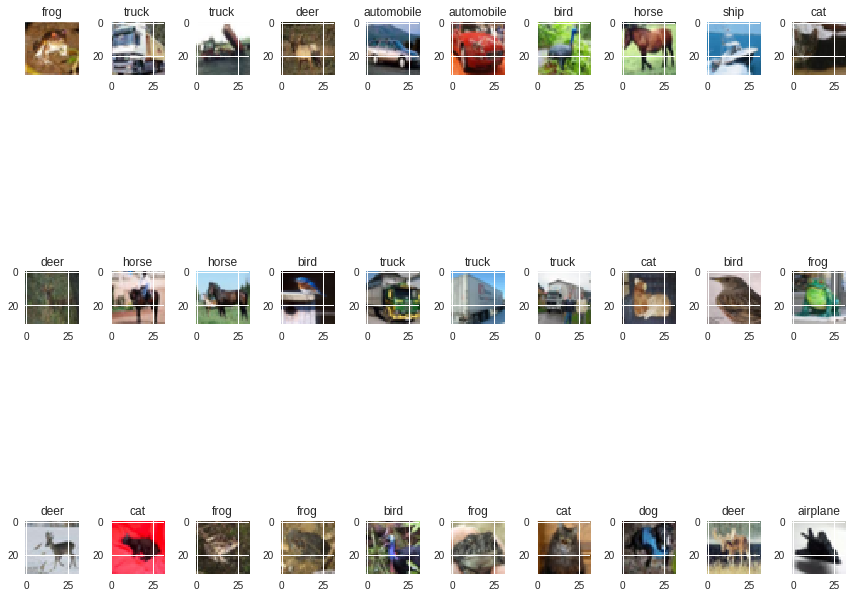

In [9]:

plt.rcParams['figure.figsize'] = (12.0,12.0)
fig,ax = plt.subplots(nrows=3,ncols=10)
ax = ax.flatten()
for i in range(30):
    img = train[i][0]
    newimg = np.dstack((img[0],img[1],img[2]))
    ax[i].imshow(newimg,interpolation='none')
    ax[i].title.set_text(cifar10_labels[train[i][1]])
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


## データセットの構成

**学習用データ**

In [10]:
print('train total data : {:<5}'.format(len(train)))
print("-------------------------------------------------------------")
train_category = []
for data, label_number in train:
    train_category.append(label_number)
  

for number, name in enumerate(cifar10_labels):
  num = train_category.count(number)
  print("{:<15} :{:>4}".format(name, num))

train total data : 40000
-------------------------------------------------------------
airplane        :3986
automobile      :3986
bird            :4048
cat             :3984
deer            :4003
dog             :3975
frog            :4020
horse           :4023
ship            :3997
truck           :3978


**検証用データ**

In [11]:
print('test total data  : {:<5}'.format(len(test)))
print('-------------------------------------------------------------')
test_category = []
for data, label_number in test:
    test_category.append(label_number)
  

for number, name in enumerate(cifar10_labels):
  num = test_category.count(number)
  print("{:<15} : {:>4}".format(name, num))

test total data  : 10000
-------------------------------------------------------------
airplane        : 1014
automobile      : 1014
bird            :  952
cat             : 1016
deer            :  997
dog             : 1025
frog            :  980
horse           :  977
ship            : 1003
truck           : 1022


**データとラベルのclassを確認**

In [12]:
print(type(train[0][0]))
print(type(train[0][1]))

<class 'numpy.ndarray'>
<class 'numpy.int32'>


# 学習

## AlexNet
**モデル定義**

In [0]:
class AlexNet(chainer.Chain):
    def __init__(self, num_class, train=True):
        super(AlexNet, self).__init__()
        with self.init_scope():
            self.conv1=L.Convolution2D(None, 96, 11, stride=2)
            self.conv2=L.Convolution2D(None, 256, 5, pad=2)
            self.conv3=L.Convolution2D(None, 384, 3, pad=1)
            self.conv4=L.Convolution2D(None, 384, 3, pad=1)
            self.conv5=L.Convolution2D(None, 256, 3, pad=1)
            self.fc6=L.Linear(None, 4096)
            self.fc7=L.Linear(None, 4096)
            self.fc8=L.Linear(None, num_class)

    def __call__(self, x):
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(self.conv1(x))), 3, stride=2)
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.fc6(h)))
        h = F.dropout(F.relu(self.fc7(h)))
        h = self.fc8(h)

        return h

In [0]:
model = L.Classifier(AlexNet(len(cifar10_labels)))


**GPU使用**

In [0]:
#GPU
gpu_id = 0
if gpu_id >= 0:
  model.to_gpu(gpu_id)

In [0]:
optimizer = optimizers.MomentumSGD()
optimizer.setup(model)

In [0]:
batchsize = 20
max_epoch = 50
mytrigger = 10
train_iter = iterators.SerialIterator(train, batchsize)
test_iter  = iterators.SerialIterator(test, batchsize, False, False)

In [0]:
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)
# iteration回数またはepochの回数を定義 #
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.dump_graph('main/loss', out_name="cg.dot"))
# snapshotする間隔を決める #
trainer.extend(extensions.snapshot(filename='snapshot_iter_{.updater.epoch}'), trigger=(mytrigger, 'epoch'))
# modelの保存 #
trainer.extend(extensions.snapshot_object(model, 'model_snapshot_{.updater.epoch}', savefun=serializers.save_npz), trigger=(mytrigger, 'epoch'))
trainer.extend(extensions.LogReport())      # lossを 1 epochごとに出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png', marker=""))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png', marker=""))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
#trainer.extend(extensions.ProgressBar(update_interval=1))


**学習開始**

In [1]:
trainer.run()

NameError: ignored

**モデル保存**

In [24]:
print('save the model')
serializers.save_npz('./result/end.model', model)

save the model


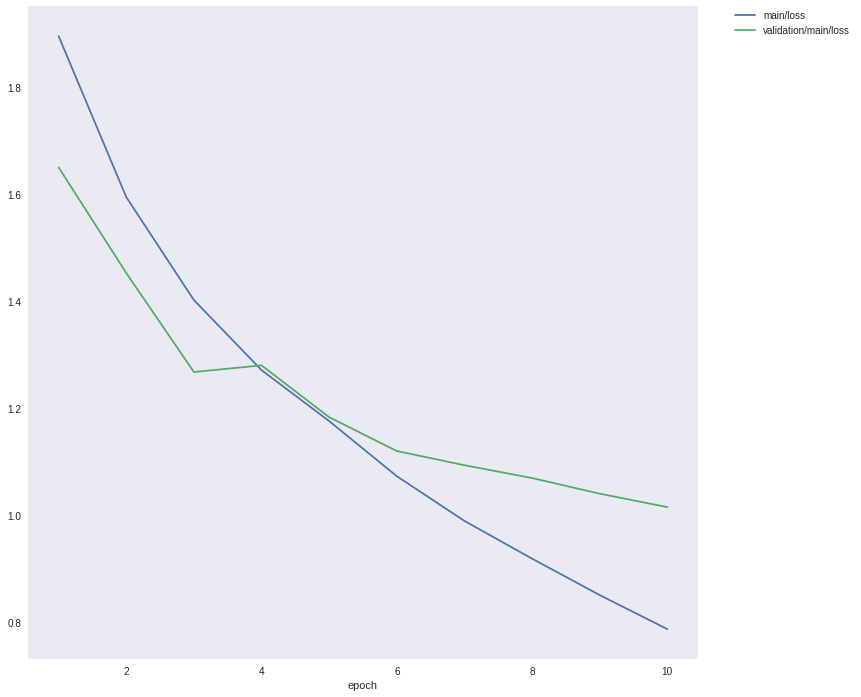

In [25]:
from IPython.display import Image
Image('result/loss.png')

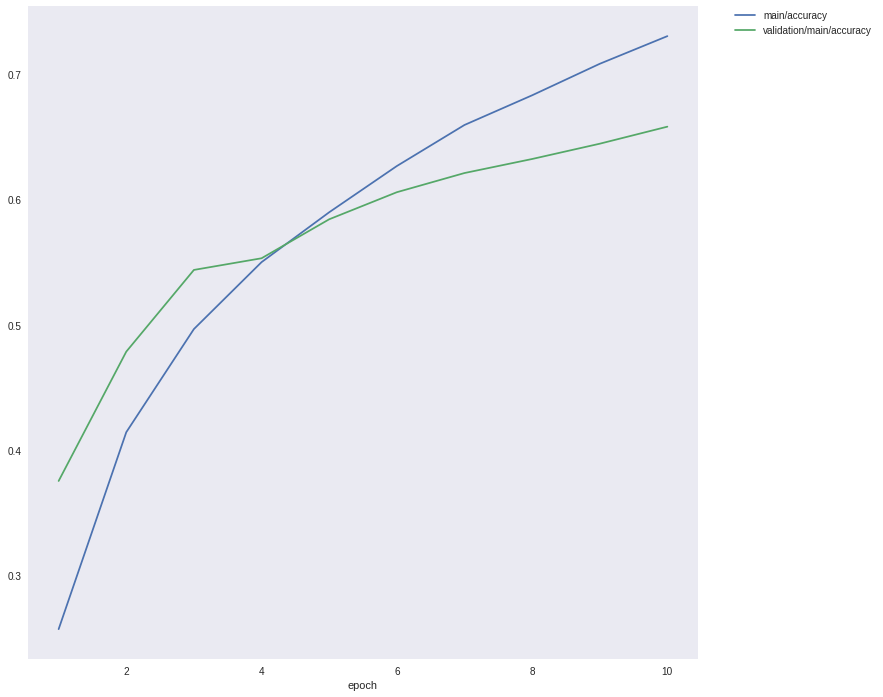

In [26]:
Image('result/accuracy.png')

**ネットワークモデル図**

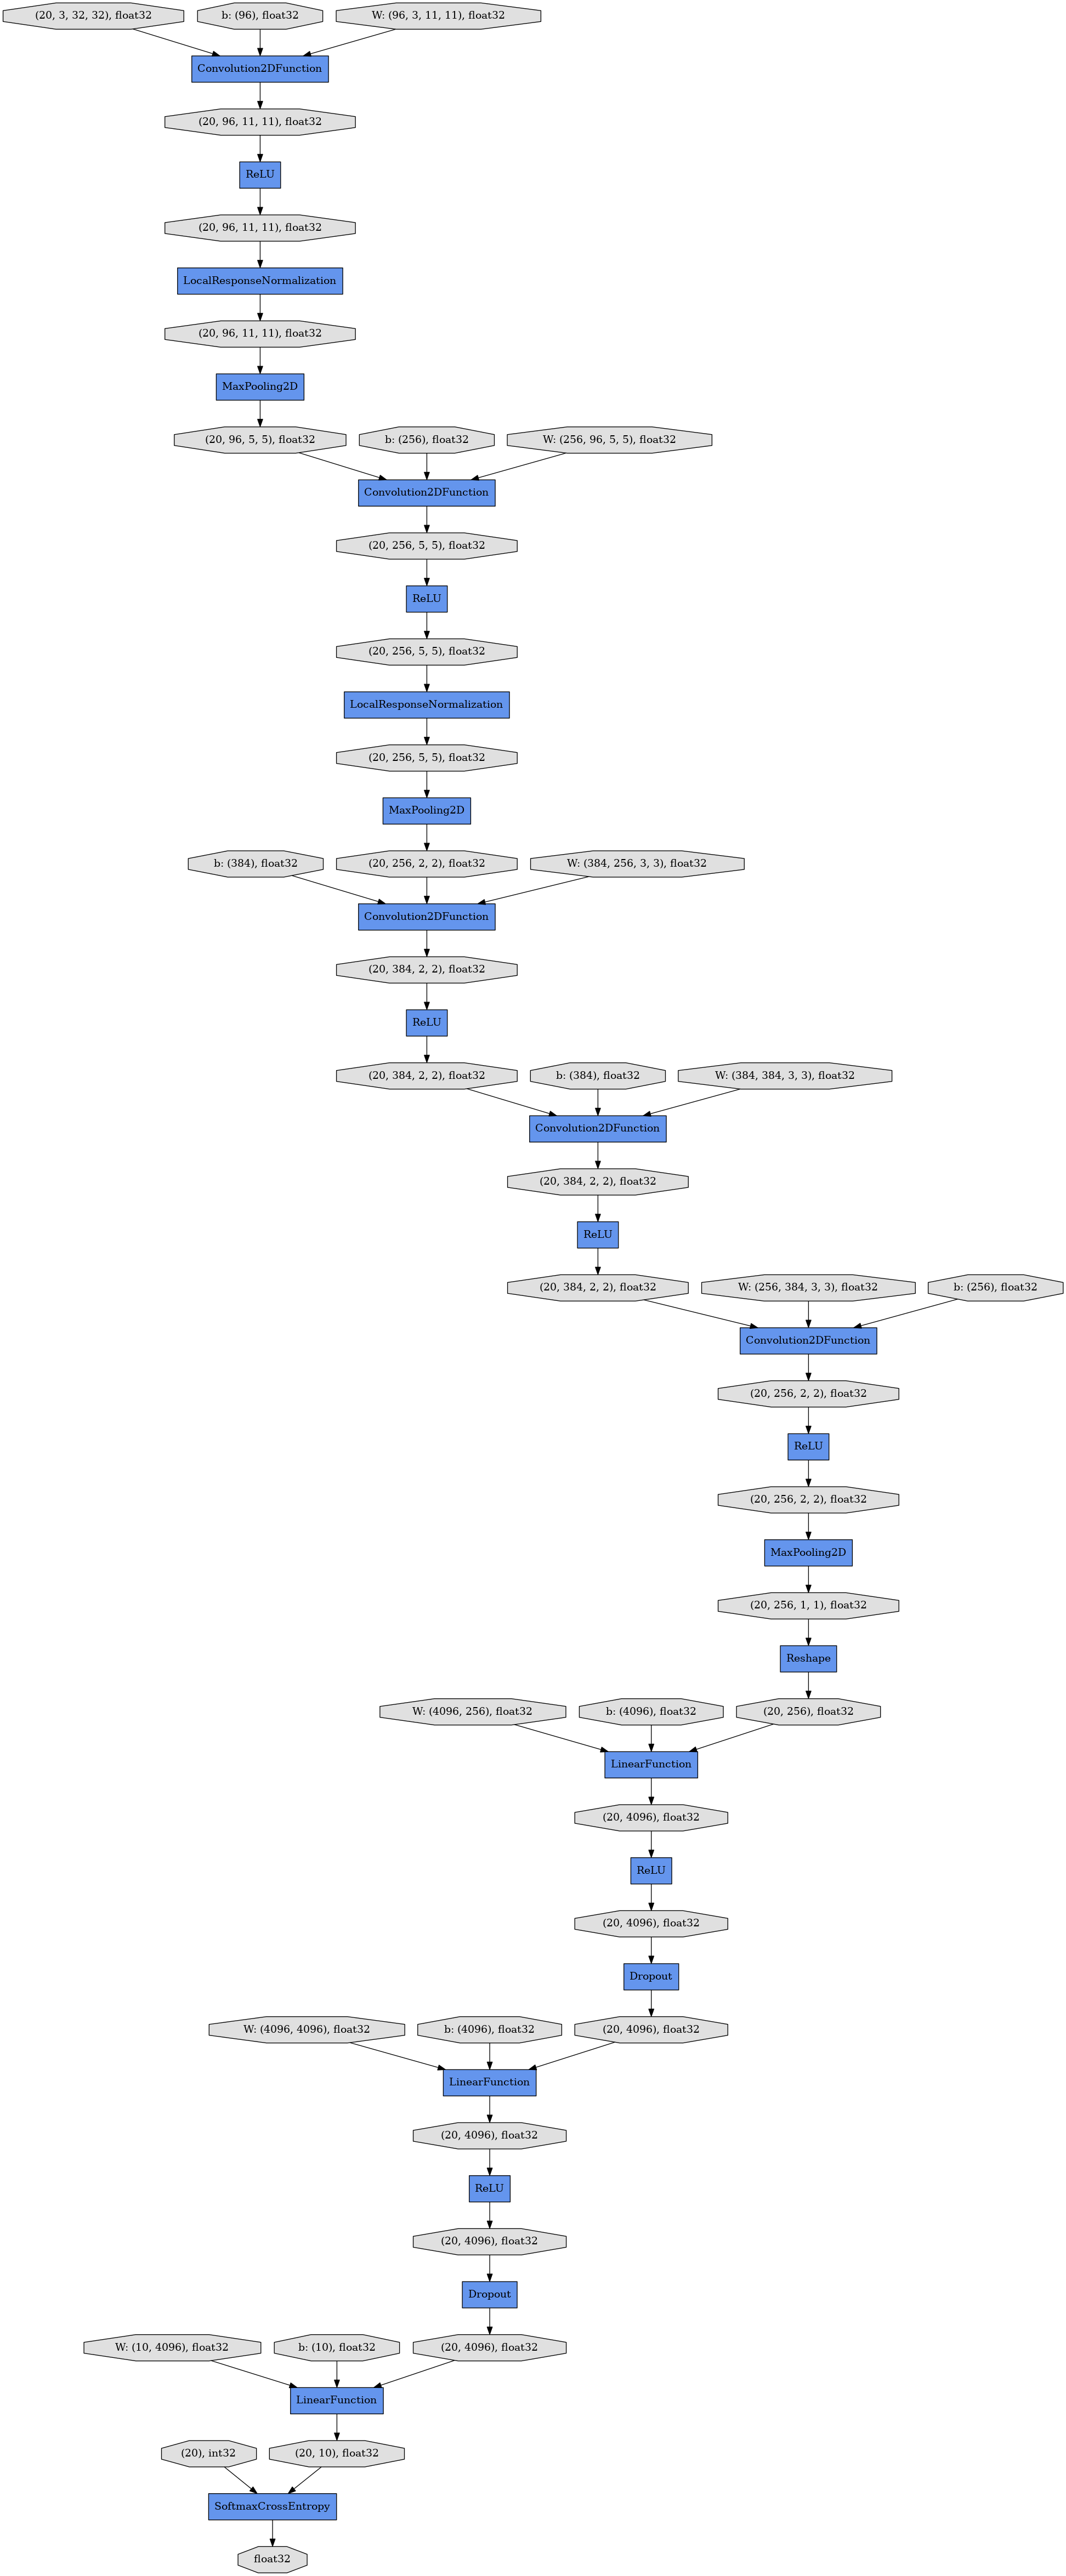

In [30]:

!dot -Tpng result/cg.dot -o result/net.png
Image('result/net.png', width=1500, height=2000)

# テスト (学習済みモデルを呼び出す)

**モデルの保存先を確認**

In [79]:
!ls result/

accuracy.png  end.model  loss.png	    net.png
cg.dot	      log	 model_snapshot_10  snapshot_iter_10


In [0]:
chainer.config.train = False
test_model =L.Classifier(AlexNet(len(cifar10_labels), train=False))

In [0]:
serializers.load_npz("./result/model_snapshot_10", test_model)

In [0]:
test_num = 100
ok = []
no = []
pred = []
for data, test_label in test_original[0:test_num][0:test_num]:
  redata = np.reshape(data, (1, 3, 32, 32))
  x = test_model.predictor(redata)
  cls = F.argmax(x)
  pred.append(cls.data)
  if(cls.data == test_label):
    ok.append(test_label)
  else:
    no.append(test_label)
  #x = test_model.predictor(redata)

In [142]:
print('total ok data: {}'.format(len(ok)))
for number, name in enumerate(cifar10_labels):
  num = ok.count(number)
  print("{:<15} : {:>4}".format(name, num))

total ok data: 75
airplane        :    6
automobile      :    6
bird            :    6
cat             :    8
deer            :    2
dog             :    4
frog            :   13
horse           :    8
ship            :   13
truck           :    9


In [143]:
print('total no data: {}'.format(len(no)))
for number, name in enumerate(cifar10_labels):
  num = no.count(number)
  print("{:<15} : {:>4}".format(name, num))

total no data: 25
airplane        :    4
automobile      :    0
bird            :    2
cat             :    2
deer            :    5
dog             :    4
frog            :    3
horse           :    3
ship            :    0
truck           :    2


In [144]:
accuracy = len(ok) / test_num

print("{} / {} = {}".format(len(ok), 
                            test_num,
                           accuracy))

75 / 100 = 0.75


In [0]:
df_result = pd.DataFrame(index=[cifar10_labels], columns=['Correct', 'Incorrect', 'Total', 'Accuracy', 'Precision', 'Recall', 'F-measure'])

In [0]:
for number, name in enumerate(cifar10_labels):
  df_result['Correct'][name] = ok.count(number)
  df_result['Incorrect'][name] = no.count(number)
  df_result['Total'][name] = total = ok.count(number) + no.count(number)
  df_result['Accuracy'][name] = accuracy = ok.count(number) / total
  df_result['Precision'][name] =  precision = ok.count(number) / pred.count(number)
  df_result['Recall'][name] = recall = ok.count(number) / len(no)
  df_result['F-measure'][name] = (2*recall*precision) / (recall+precision)

In [172]:

df_result.round(3)

,Correct,Incorrect,Total,Accuracy,Precision,Recall,F-measure
airplane,6,4,10,0.6,0.857,0.24,0.375
automobile,6,0,6,1,1,0.24,0.387
bird,6,2,8,0.75,0.545,0.24,0.333
cat,8,2,10,0.8,0.727,0.32,0.444
deer,2,5,7,0.286,0.5,0.08,0.138
dog,4,4,8,0.5,0.8,0.16,0.267
frog,13,3,16,0.812,0.867,0.52,0.65
horse,8,3,11,0.727,0.667,0.32,0.432
ship,13,0,13,1,0.765,0.52,0.619
truck,9,2,11,0.818,0.75,0.36,0.486
